# Packages import

In [1]:
import pickle
import re
from sklearn.neural_network import MLPRegressor
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
df=pd.read_excel("Sales_data.xlsx")

In [3]:
df.head(10)

,CodeProduit,Pays,Date
0,lot,royaume-uni,06 Octobre 2014
1,smlt,royaume-uni,06 Octobre 2014
2,dsmlt,états-unis d'amérique,06 Octobre 2014
3,2x,royaume-uni,06 Octobre 2014
4,rouge,états-unis d'amérique,06 Octobre 2014
5,2x,italie,06 Octobre 2014
6,2 trans,france,06 Octobre 2014
7,lot,france,06 Octobre 2014
8,1x,france,06 Octobre 2014
9,dsmlt,france,06 Octobre 2014


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10433 entries, 0 to 10432
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CodeProduit  10433 non-null  object
 1   Pays         8068 non-null   object
 2   Date         10433 non-null  object
dtypes: object(3)
memory usage: 244.6+ KB


In [5]:
# Cette Data Frame représente 6880 lignes et 4 colonnes sans valeurs manquantes
df["Pays"].unique()

array(['royaume-uni', "états-unis d'amérique", 'italie', 'france',
       'irlande', 'pays-bas', 'grèce', 'oman', 'canada', 'australie',
       'allemagne', nan, 'brooklyn', 'espagne', 'belgique', 'chypre',
       'danemark', 'hong kong', 'malte', 'united kingdom', 'chili',
       'autriche', 'norvège', 'deutschland', 'malta',
       'france métropolitaine', 'emirats arabes unis', 'malaysia',
       'croatie', 'suède', 'république tchèque', 'hongrie', 'usa',
       'qatar', 'greece', 'kuwait', 'luxembourg', 'nouvelle-zélande',
       'finland', 'nouvelle-calédonie', 'malaisie', 'slovénie',
       'south africa', 'saudi arabia', 'turquie', 'nederlanad', 'suisse',
       'liban', 'pologne', 'lituanie', 'united states', 'bulgarie',
       'corée du sud', 'singapour', 'portugal', 'estonie', 'denmark',
       'latvia', 'germany', 'spain', 'belgium', 'sweden', 'italy',
       'hungary', 'brunei', 'russia', 'norway', 'roumanie', 'switzerland',
       'czech republic', 'cyprus', 'new zealand',

In [6]:
df["Date"].unique()

array(['06 Octobre 2014', '10 Novembre 2014', '12 Octobre 2014', ...,
       '21 September 2023', '25 September 2023', '29 September 2023'],
      dtype=object)

# Data cleaning

In [7]:
# Dictionnaire de correspondance des noms de mois avec leurs numéros
falseCountries_to_correct = {
    'usa': "états-unis d'amérique",'brooklyn':"états-unis d'amérique", "etats-unis":"états-unis d'amérique", 'deutschland': 'allemagne','malta': 'malte','france métropolitaine':'france', 'malaysia': 'malaisie','south africa': 'afrique de sud', 'nederlanad': 'pays-bas', 'united states': "états-unis d'amérique", 'germany': 'allemagne','spain':'espagne','belgium':'belgique',
    'sweden': 'suède', 'italy': 'italie', 'hungary': 'hongrie','norway': 'norvège','Croatia': 'croatie','new zealand': 'nouvelle-zélande','nederland':'pays-bas','saudi arabia':'arabie saoudite', 'switzerland': 'suisse','denmark':'danemark', 'czech republic': 'république tchèque',
    'poland':'pologne', "greece":"grèce","mexico":"mexique","irlande (eire)":"irlande","japan":"japon","thailand":"thailande","russia":"russie", "royaume-uni":"united kingdom"
}
# Fonction pour remplacer les noms de pays par leurs noms correspondants
def replace_country(c_str):
    for c, cc in falseCountries_to_correct.items():
        if not pd.isna(c_str) and c in c_str:
            return c_str.replace(c, cc)
    return c_str  # Retourne la chaîne inchangée si aucun remplacement n'est effectué

# Application de la fonction sur la colonne "Pays"
df['Pays'] = df['Pays'].apply(replace_country)

In [8]:
df["Pays"].unique()

array(['united kingdom', "états-unis d'amérique", 'italie', 'france',
       'irlande', 'pays-bas', 'grèce', 'oman', 'canada', 'australie',
       'allemagne', nan, 'espagne', 'belgique', 'chypre', 'danemark',
       'hong kong', 'malte', 'chili', 'autriche', 'norvège',
       'emirats arabes unis', 'malaisie', 'croatie', 'suède',
       'république tchèque', 'hongrie', 'qatar', 'kuwait', 'luxembourg',
       'nouvelle-zélande', 'finland', 'nouvelle-calédonie', 'slovénie',
       'afrique de sud', 'arabie saoudite', 'turquie', 'suisse', 'liban',
       'pologne', 'lituanie', 'bulgarie', 'corée du sud', 'singapour',
       'portugal', 'estonie', 'latvia', 'brunei', 'russie', 'roumanie',
       'cyprus', 'argentine', 'croatia', 'slovaquie', 'japon',
       'south korea', 'thailande', 'mexique'], dtype=object)

In [9]:
# Dictionnaire de correspondance des noms de mois avec leurs numéros
month_to_num = {
    'Janvier': '01', 'janvier': '01', 'JANV':'01', 'Février': '02','Vévrier': '02','FEV':'02', 'Mars': '03', 'MARS':'03', 'mars': '03', 'Avril': '04', 'Mai': '05', 'MAI':'05', 'MA':'05', 'Juin': '06','June':'06','JUIN':'06','JUN':'06', 'Jun':'06',
    'Juillet': '07', 'Jullet': '07', 'Juill': '07', 'Aout': '08','Août':'08', 'Septembre': '09', 'September': '09','Sept': '09','sept': '09','Saptembre':'09','Spt':'09', 'Octobre': '10','OCT':'10', 'Novembre': '11',
    'Novembe':'11','NOV':'11', 'Décembre': '12','December':'12','DECEMBRE':'12', 'DEC':'12'
}
# Fonction pour remplacer les noms de mois par leurs numéros correspondants
def replace_month(date_str):
    for month, num in month_to_num.items():
        if month in date_str:
            return date_str.replace(month, num)
    return date_str  # Retourne la chaîne inchangée si aucun remplacement n'est effectué

# Application de la fonction sur la colonne "Date"
df['Date'] = df['Date'].apply(replace_month)


Nous avons remplacé chaque mois par son rang

Nous avons fait des modification sur la colonne date pour atteindre la format suivante : dd-mm-yyyy

In [10]:
# Fonction pour reformater la date
def reformat_date(date_str):
    date_str = re.sub(r'\s{2,}', ' ', date_str).strip()
    return date_str.strip().replace(' ', '-')

# Application de la fonction sur la colonne "Date"
df['Date'] = df['Date'].apply(reformat_date)

# Affichage du DataFrame avec les dates reformatées
df.head()

,CodeProduit,Pays,Date
0,lot,united kingdom,06-10-2014
1,smlt,united kingdom,06-10-2014
2,dsmlt,états-unis d'amérique,06-10-2014
3,2x,united kingdom,06-10-2014
4,rouge,états-unis d'amérique,06-10-2014


In [11]:
# Vérifier les valeurs qui ne correspondent pas au format 'dd-mm-yyyy'
invalid_dates = df[~df['Date'].str.match(r'\d{1,2}-\d{2}-\d{4}')]

# Afficher les valeurs invalides
print("Valeurs de la colonne 'Date' qui ne correspondent pas au format 'dd-mm-yyyy': ", invalid_dates.shape[0])

Valeurs de la colonne 'Date' qui ne correspondent pas au format 'dd-mm-yyyy':  0


In [13]:
# Remplacer les valeurs 'États-Unis d'Amérique' par 'USA' dans la colonne 'Pays'
df['Pays'] = df['Pays'].replace('états-unis d\'amérique', 'USA')

Aprés le netoyage de nos données, notre base contient 6710 lignes et 3 colonnes: CodeProduit, Pays, Date .
Aussi on remarque qu'on n'a pas des valeurs nulles.

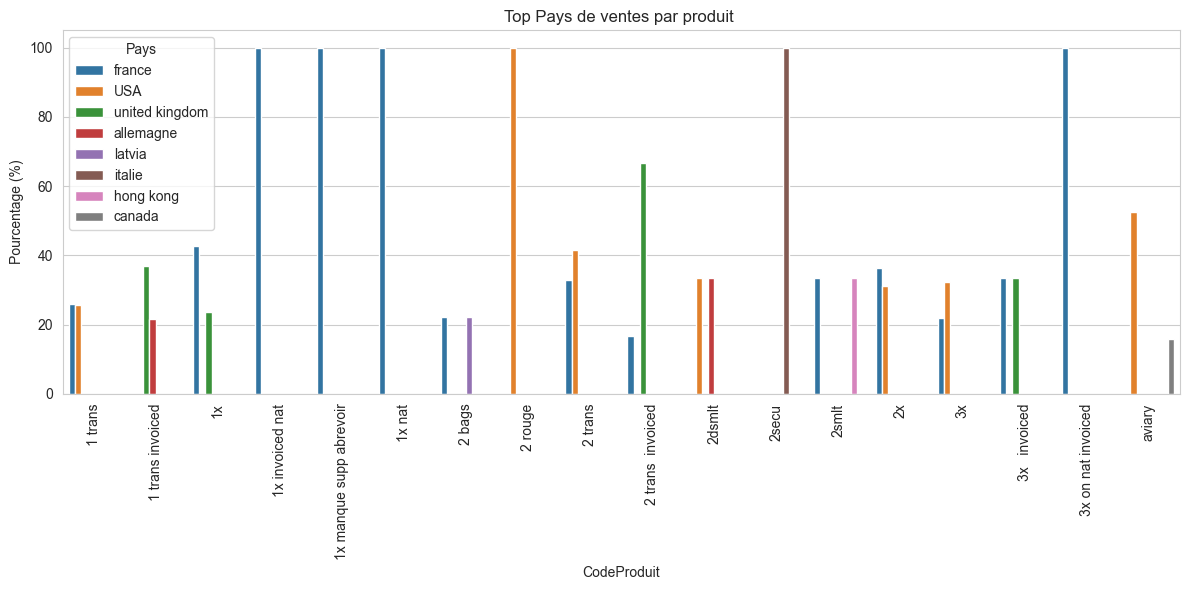

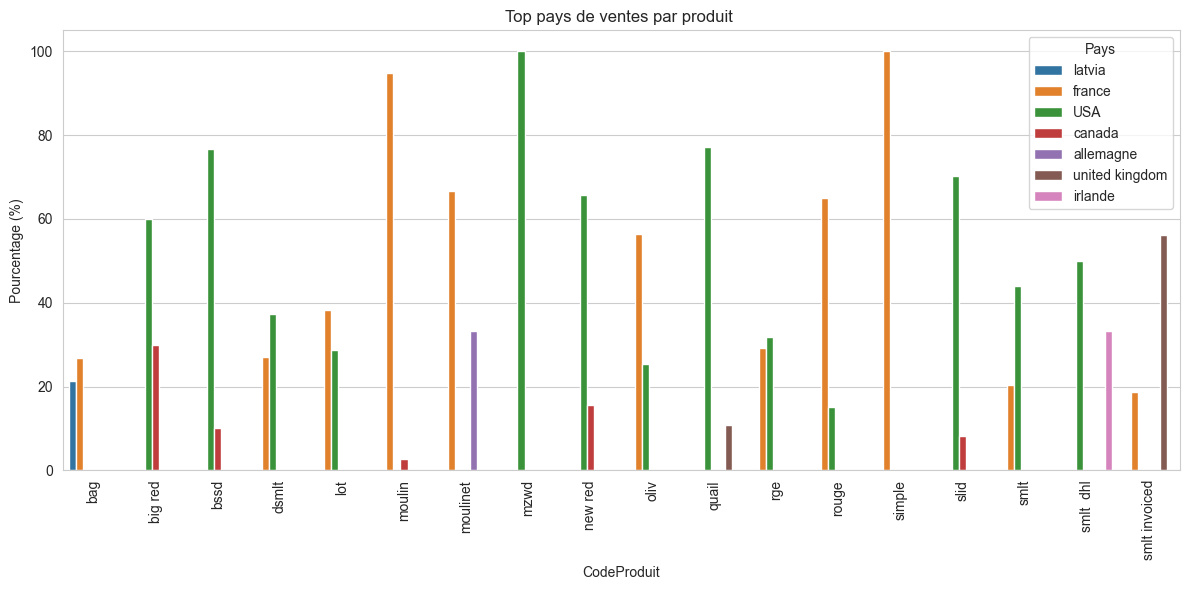

In [14]:
# Importer les bibliothèques
import matplotlib.pyplot as plt
import seaborn as sns
# Trier les données par CodeProduit
# Compter les occurrences pour chaque produit et pays
grouped = df.groupby(['CodeProduit', 'Pays']).size().reset_index(name='NombreVentes')

# Calculer les pourcentages
grouped['Pourcentage'] = grouped.groupby('CodeProduit')['NombreVentes'].transform(lambda x: x / x.sum() * 100)

# Trier et sélectionner les deux plus grands pourcentages
top2 = grouped.sort_values(['CodeProduit', 'Pourcentage'], ascending=[True, False]).groupby('CodeProduit').head(2)

top2_sorted = top2.sort_values(by='CodeProduit')
# Diviser en deux groupes
n = len(top2_sorted['CodeProduit'].unique()) // 2
group1 = top2_sorted[top2_sorted['CodeProduit'].isin(top2_sorted['CodeProduit'].unique()[:n])]
group2 = top2_sorted[top2_sorted['CodeProduit'].isin(top2_sorted['CodeProduit'].unique()[n:])]


# Créer un graphique pour le groupe 1
plt.figure(figsize=(12, 6))
sns.barplot(data=group1, x='CodeProduit', y='Pourcentage', hue='Pays')
plt.title("Top Pays de ventes par produit ")
plt.ylabel("Pourcentage (%)")
plt.xlabel("CodeProduit")
plt.xticks(rotation=90)
plt.legend(title="Pays")
plt.tight_layout()
plt.show()

# Créer un graphique pour le groupe 2
plt.figure(figsize=(12, 6))
sns.barplot(data=group2, x='CodeProduit', y='Pourcentage', hue='Pays')
plt.title("Top pays de ventes par produit ")
plt.ylabel("Pourcentage (%)")
plt.xlabel("CodeProduit")
plt.xticks(rotation=90)
plt.legend(title="Pays")
plt.tight_layout()
plt.show()



          CodeProduit  NombreNulls  PourcentageNulls  NombreVentes
0             1 trans           45          1.902748           685
1    1 trans invoiced            3          0.126850            49
2                  1x          351         14.841438          1206
3              1x nat            2          0.084567             4
4              2 bags            3          0.126850            12
5             2 rouge            2          0.084567             6
6             2 trans          196          8.287526           832
7   2 trans  invoiced            1          0.042283             7
8              2dsmlt            1          0.042283             4
9               2smlt            1          0.042283             4
10                 2x          258         10.909091          1093
11                 3x          811         34.291755          3256
12      3x   invoiced            4          0.169133            28
13             aviary           14          0.591966          

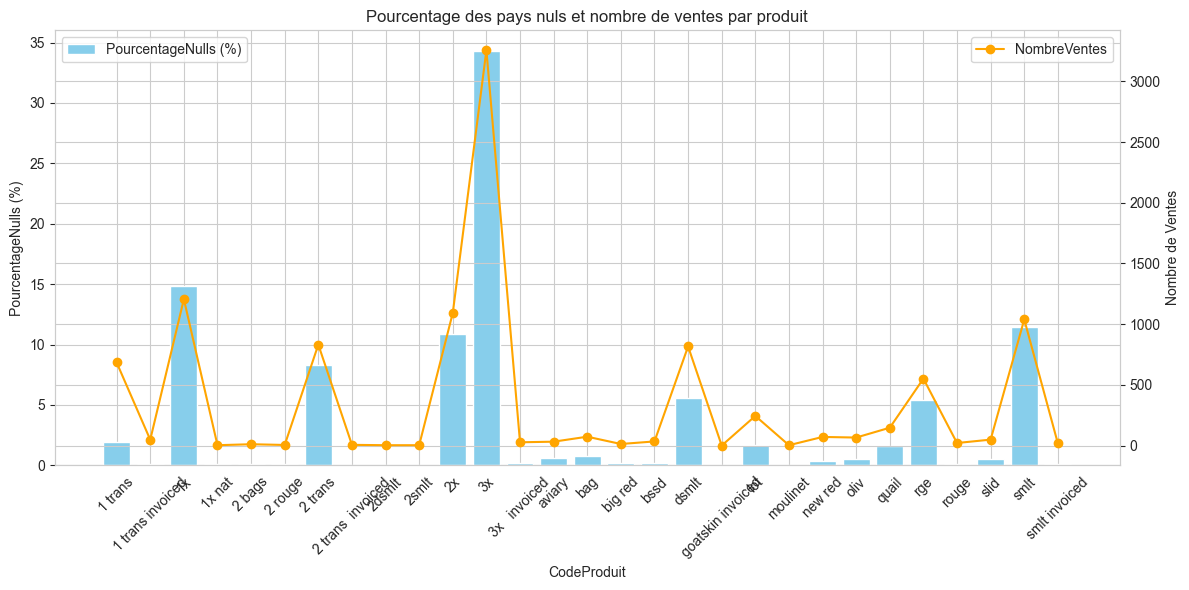

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Supposons que votre DataFrame s'appelle df
# Calculer le total des ventes par produit
total_sales = df.groupby('CodeProduit').size().reset_index(name='NombreVentes')

# Filtrer les lignes où "Pays" est nul
nulls = df[df['Pays'].isnull()]

# Compter les nulls par produit
null_counts = nulls.groupby('CodeProduit').size().reset_index(name='NombreNulls')

# Calculer le total global des nulls
total_nulls = null_counts['NombreNulls'].sum()

# Calculer les pourcentages de nulls pour chaque produit
null_counts['PourcentageNulls'] = (null_counts['NombreNulls'] / total_nulls) * 100

# Fusionner avec le total des ventes
result = pd.merge(null_counts, total_sales, on='CodeProduit', how='left')

# Afficher le résultat final
print(result)



# Créer le graphique
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe pour le pourcentage de nulls
ax1.bar(result['CodeProduit'], result['PourcentageNulls'], color='skyblue', label='PourcentageNulls (%)')
ax1.set_ylabel('PourcentageNulls (%)')
ax1.set_xlabel('CodeProduit')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Axe pour le nombre de ventes
ax2 = ax1.twinx()
ax2.plot(result['CodeProduit'], result['NombreVentes'], color='orange', marker='o', label='NombreVentes')
ax2.set_ylabel('Nombre de Ventes')
ax2.legend(loc='upper right')

plt.title('Pourcentage des pays nuls et nombre de ventes par produit')
plt.tight_layout()
plt.show()



In [16]:
# remplissage

# Define the mapping for 'CodeProduit' and their corresponding 'Pays' values
product_country_map = {
    '1 trans': 'france',
    '1 trans invoiced': 'united kingdom',
    '1x': 'france',
    '1x nat': 'france',
    '2 rouge': 'USA',
    '2 trans': 'USA',
    '2 trans  invoiced': 'united kingdom',
    '2x': 'france',
    '3x': 'USA',
    'aviary': 'USA',
    'bag': 'france',
    'big red': 'USA',
    'bssd': 'USA',
    'dsmlt': 'USA',
    'lot': 'france',
    'moulinet': 'france',
    'new red': 'USA',
    'oliv': 'france',
    'quail': 'USA',
    'rge': 'USA',
    'rouge': 'france',
    'slid': 'USA',
    'smlt': 'USA',
    'smlt invoiced': 'united kingdom'
}

# Update 'Pays' based on the mapping for non-null 'Pays'
for product, country in product_country_map.items():
    df.loc[(df['CodeProduit'] == product) & (df['Pays'].isnull()), 'Pays'] = country

# Drop the rows where 'CodeProduit' is '2 bags', '2dsmlt', or '3x invoiced', 
# and 'Pays' is null in a single step for efficiency
df = df[~((df['CodeProduit'] == '2 bags') & (df['Pays'].isnull()))]
df = df[~((df['CodeProduit'] == '2dsmlt') & (df['Pays'].isnull()))]
df = df[~((df['CodeProduit'] == '3x   invoiced') & (df['Pays'].isnull()))]
df = df[~((df['CodeProduit'] == 'goatskin invoiced') & (df['Pays'].isnull()))]
df = df[~((df['CodeProduit'] == '2smlt') & (df['Pays'].isnull()))]

In [17]:
# Vérification des résultats
codes_produits_nulls = df[df['Pays'].isnull()]['CodeProduit'].unique()

# Afficher les résultats
print(codes_produits_nulls)


[]


In [18]:
df['sales_number'] = df.groupby(['CodeProduit', 'Pays', 'Date'])['CodeProduit'].transform('count').astype(int)
df

,CodeProduit,Pays,Date,sales_number
0,lot,united kingdom,06-10-2014,1
1,smlt,united kingdom,06-10-2014,2
2,dsmlt,USA,06-10-2014,1
3,2x,united kingdom,06-10-2014,1
4,rouge,USA,06-10-2014,1
...,...,...,...,...
10428,dsmlt,allemagne,29-09-2023,1
10429,3x,espagne,29-09-2023,1
10430,2x,france,29-09-2023,2
10431,1x,united kingdom,29-09-2023,2


In [19]:
df=df.drop_duplicates()
df.duplicated().sum()

0

 Keep products that have at least 30 observations 

In [20]:
# Group by 'CodeProduit' and calculate total sales
total_sales = df.groupby('CodeProduit')['sales_number'].sum()

# Filter for products with total sales >= 30
valid_products = total_sales[total_sales >= 30].index

# Keep only rows with valid CodeProduit
df = df[df['CodeProduit'].isin(valid_products)]

# Display the result
print(df)

# GVerify total sales > 30 
total_sales = df.groupby('CodeProduit')['sales_number'].sum()

# Print the result
print(total_sales)


      CodeProduit            Pays        Date  sales_number
0             lot  united kingdom  06-10-2014             1
1            smlt  united kingdom  06-10-2014             2
2           dsmlt             USA  06-10-2014             1
3              2x  united kingdom  06-10-2014             1
5              2x          italie  06-10-2014             1
...           ...             ...         ...           ...
10426        smlt             USA  29-09-2023             1
10427          2x          france  29-09-2023             2
10428       dsmlt       allemagne  29-09-2023             1
10429          3x         espagne  29-09-2023             1
10432        smlt  united kingdom  29-09-2023             1

[7126 rows x 4 columns]
CodeProduit
1 trans              685
1 trans invoiced      49
1x                  1206
2 trans              832
2x                  1093
3x                  3256
aviary                33
bag                   74
bssd                  35
dsmlt             

In [21]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7126 entries, 0 to 7125
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CodeProduit   7126 non-null   object
 1   Pays          7126 non-null   object
 2   Date          7126 non-null   object
 3   sales_number  7126 non-null   int32 
dtypes: int32(1), object(3)
memory usage: 195.0+ KB


In [22]:
df.to_excel('Cleaned_Sales_Data.xlsx', index=False)

# Data Visualisation

In [23]:
df['Pays'].unique()

array(['united kingdom', 'USA', 'italie', 'france', 'irlande', 'pays-bas',
       'grèce', 'oman', 'canada', 'australie', 'allemagne', 'espagne',
       'belgique', 'chypre', 'danemark', 'hong kong', 'malte', 'chili',
       'autriche', 'norvège', 'emirats arabes unis', 'croatie', 'suède',
       'république tchèque', 'hongrie', 'qatar', 'kuwait', 'luxembourg',
       'nouvelle-zélande', 'finland', 'nouvelle-calédonie', 'malaisie',
       'slovénie', 'afrique de sud', 'arabie saoudite', 'turquie',
       'suisse', 'liban', 'pologne', 'lituanie', 'bulgarie',
       'corée du sud', 'singapour', 'portugal', 'estonie', 'latvia',
       'brunei', 'russie', 'roumanie', 'cyprus', 'argentine', 'croatia',
       'slovaquie', 'japon', 'south korea', 'thailande', 'mexique'],
      dtype=object)

 ### Voici la visualisation des nombre de ventes en fonction des Pays.

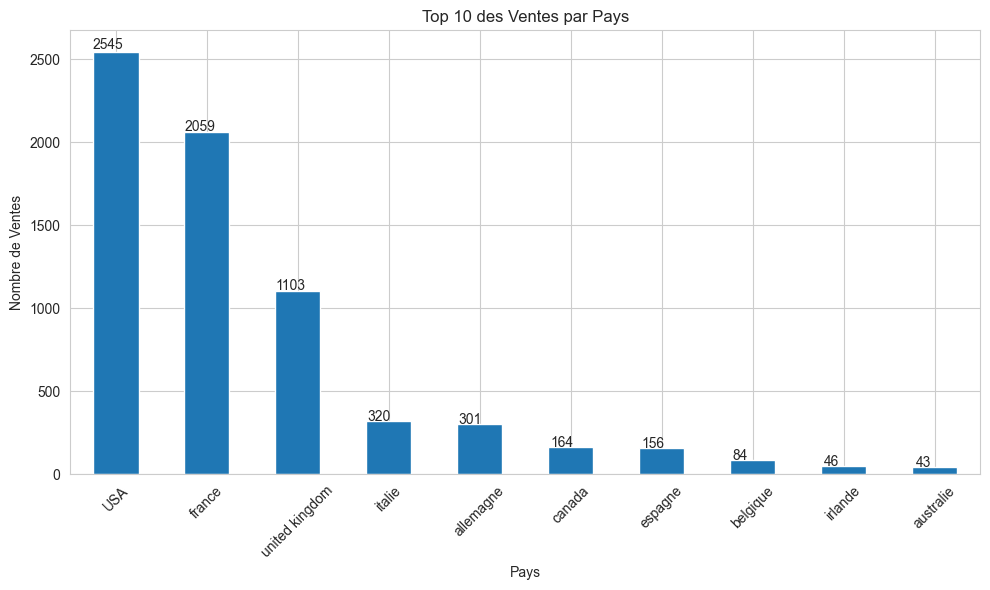

In [24]:
import matplotlib.pyplot as plt

# Grouper les données par pays et calculer le total des ventes par pays
sales_by_country = df.groupby('Pays').size().sort_values(ascending=False)

# Sélectionner les 10 premiers pays en fonction des ventes
top_10_countries = sales_by_country.head(10)

# Créer un graphique à barres pour visualiser les 10 premiers pays en fonction des ventes
plt.figure(figsize=(10, 6))
ax = top_10_countries.plot(kind='bar')
plt.title('Top 10 des Ventes par Pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de Ventes')
plt.xticks(rotation=45)

# Ajouter les valeurs sur chaque barre
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() * 1.005, i.get_height() * 1.005))

plt.tight_layout()
plt.show()


##### On remarque que USA et France ont la plupart des nombre d'achats (2545 + 2059 parmis 7126) => 64%

### On a fait l'extraction des sommes des sales_number pour chaque mois pour visualiser le nombre de ventes en fonction des mois.

In [25]:
# Convertir la colonne 'Date' en format de date
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extraire le mois à partir de la colonne 'Date'
df['month'] = df['Date'].dt.month

# Grouper les données par mois
sales_by_month = df.groupby('month').size().reset_index(name='Sales')


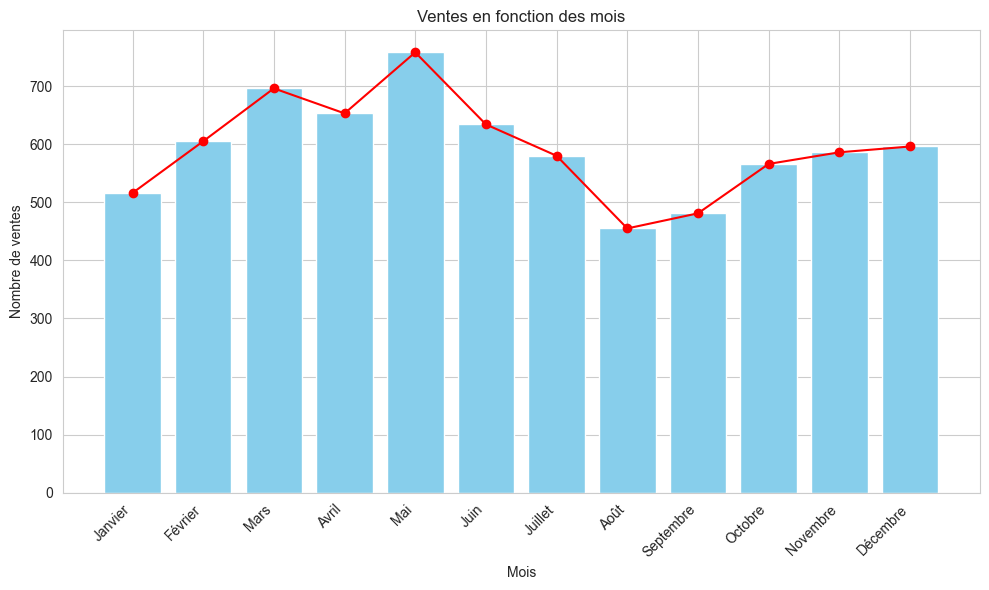

In [26]:
# Créer un dictionnaire pour mapper les nombres de mois aux noms des mois
month_names = {
    1: 'Janvier',
    2: 'Février',
    3: 'Mars',
    4: 'Avril',
    5: 'Mai',
    6: 'Juin',
    7: 'Juillet',
    8: 'Août',
    9: 'Septembre',
    10: 'Octobre',
    11: 'Novembre',
    12: 'Décembre'
}

# Appliquer le mapping des noms de mois à la colonne 'Month'
sales_by_month['Month'] = sales_by_month['month'].map(month_names)
plt.figure(figsize=(10, 6))
plt.bar(sales_by_month["Month"], sales_by_month["Sales"], color='skyblue')
plt.plot(sales_by_month["Month"], sales_by_month["Sales"], color='red', marker='o', linestyle='-')

plt.title('Ventes en fonction des mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### => Nous pouvons constater une évolution des ventes dans les mois de mai et juin (1200) , mais on remarque aussi une chute dans les mois de janvier, aout et septembre.

# Machine Learning

In [27]:
df = df.drop("month", axis=1)
df = df.set_index("Date")
df

,CodeProduit,Pays,sales_number
Date,,,
2014-10-06,lot,united kingdom,1
2014-10-06,smlt,united kingdom,2
2014-10-06,dsmlt,USA,1
2014-10-06,2x,united kingdom,1
2014-10-06,2x,italie,1
...,...,...,...
2023-09-29,smlt,USA,1
2023-09-29,2x,france,2
2023-09-29,dsmlt,allemagne,1


## Time Series EDA

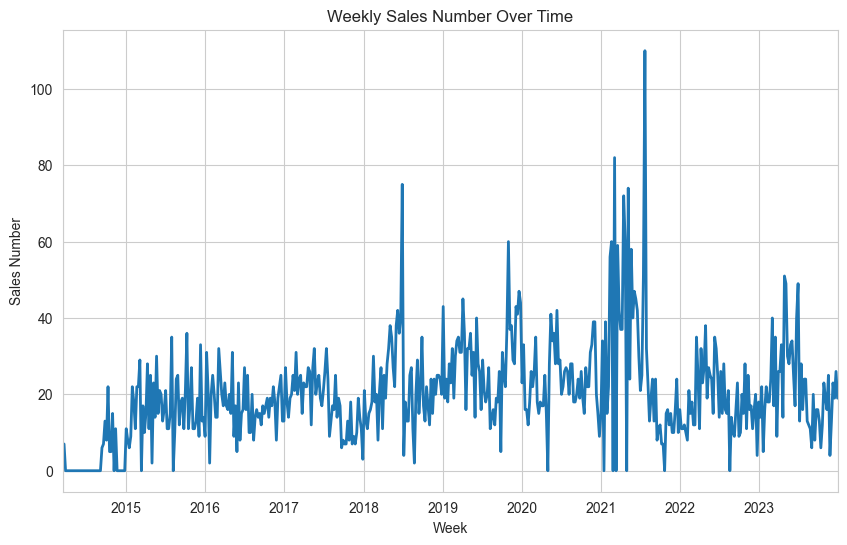

In [28]:
# Loop through each product's dataframe and perform EDA  
# Aggregate sales numbers by week
weekly_sales = df['sales_number'].resample('W').sum()

# Plot the weekly aggregated Time Series Data
plt.figure(figsize=(10, 6))
weekly_sales.plot(title=f'Weekly Sales Number Over Time', lw=2)
plt.xlabel('Week')
plt.ylabel('Sales Number')
plt.grid(True)
plt.show()

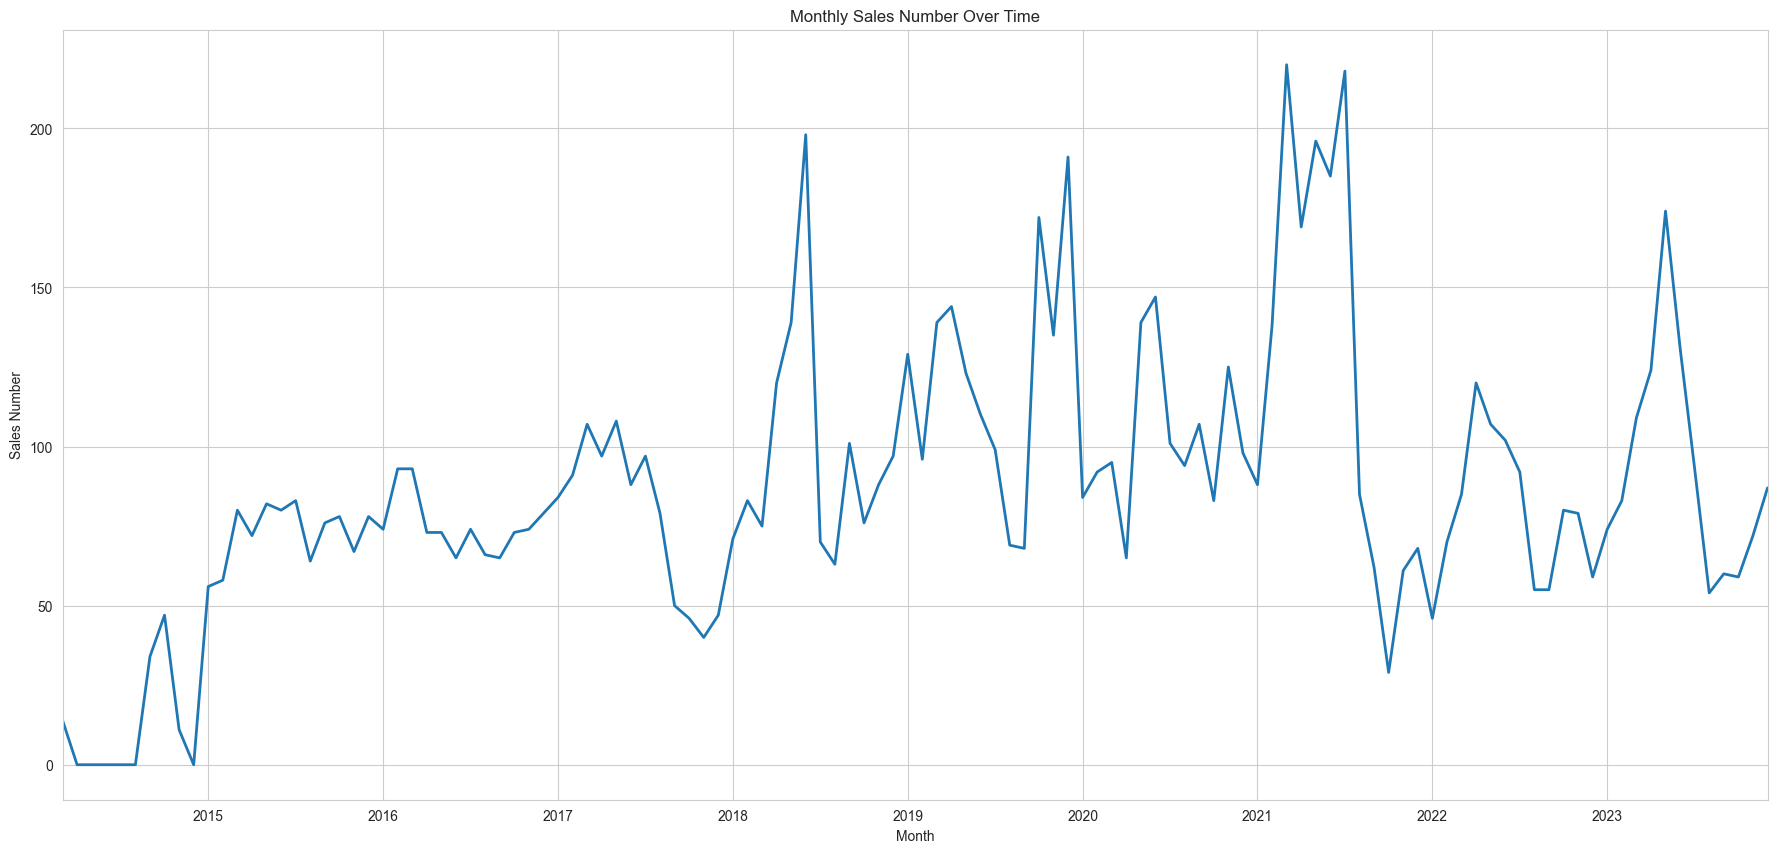

In [29]:
# per mounth 
  
# Aggregate sales numbers by month
monthly_sales = df['sales_number'].resample('M').sum()

# Plot the monthly aggregated Time Series Data
plt.figure(figsize=(22, 10))
monthly_sales.plot(title=f'Monthly Sales Number Over Time', lw=2)
plt.xlabel('Month')
plt.ylabel('Sales Number')
plt.grid(True)
plt.show()

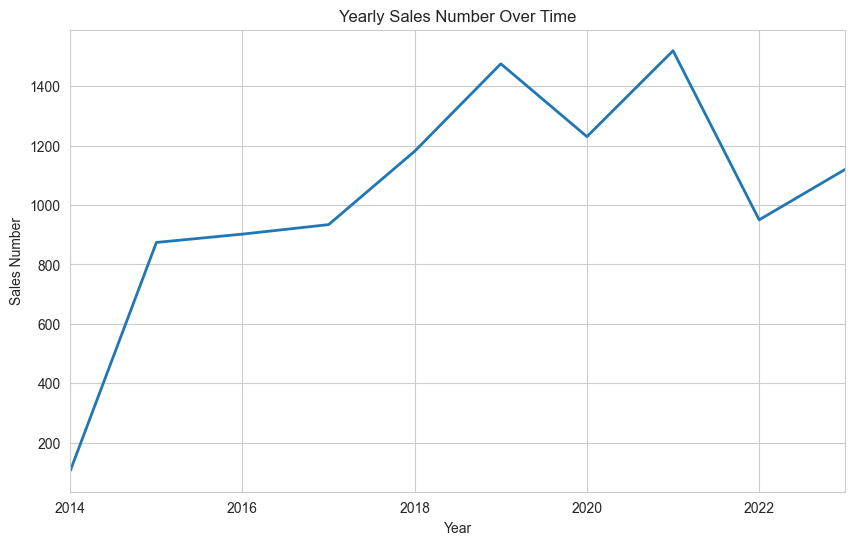

In [30]:
# per year 
# Aggregate sales numbers by year
yearly_sales = df['sales_number'].resample('Y').sum()

# Plot the yearly aggregated Time Series Data
plt.figure(figsize=(10, 6))
yearly_sales.plot(title=f'Yearly Sales Number Over Time', lw=2)
plt.xlabel('Year')
plt.ylabel('Sales Number')
plt.grid(True)
plt.show()


## Statistical Tests

#### Stationarity

In [31]:
# 6. Check for Stationarity (Augmented Dickey-Fuller Test)
result = adfuller(df['sales_number'])  # ADF Test
print(f"\nAugmented Dickey-Fuller Test for Stationarity: {product}")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


Augmented Dickey-Fuller Test for Stationarity: smlt invoiced
ADF Statistic: -8.456296281188925
p-value: 1.6114763844684061e-13
The time series is likely stationary.


In [32]:
result_kpss = kpss(df['sales_number'], regression='c')  # KPSS Test (c for constant)
print(f"KPSS Test for Stationarity: {product}")
print(f"KPSS Statistic: {result_kpss[0]}")
print(f"p-value: {result_kpss[1]}")
if result_kpss[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

KPSS Test for Stationarity: smlt invoiced
KPSS Statistic: 2.521653687739356
p-value: 0.01
The time series is likely stationary.


## Modeling :

In [33]:
def fill_missing_dates(df, start_date=None, end_date=None):

    df_reset = df.reset_index()

    # Determine the date range
    if not start_date:
        start_date = df_reset['Date'].min()
    if not end_date:
        end_date = df_reset['Date'].max()

    # Generate a complete date range
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a cartesian product of all dates with product_code and country
    product_country = df_reset[['CodeProduit', 'Pays']].drop_duplicates()
    complete_index = pd.DataFrame(
        [(product, country, date) for date in all_dates
                                   for product, country in product_country.values],
        columns=['CodeProduit', 'Pays', 'Date']
    )

    # Merge the original data with the complete index (based on product_code, country, and date)
    df_complete = pd.merge(complete_index, df_reset, on=['CodeProduit', 'Pays', 'Date'], how='left')

    # Fill missing sales_number with 0
    df_complete['sales_number'] = df_complete['sales_number'].fillna(0)

    # Set the 'date' column as the index again
    df_complete.set_index('Date', inplace=True)

    return df_complete


In [34]:
df = fill_missing_dates(df)

In [35]:
def preprocess_data(df, encoder_exists=False):
    encoder = None
    if encoder_exists:
        with open('encoder.pkl', 'rb') as f:
            encoder = pickle.load(f)
    else:
        # Initialize and fit the encoder
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoder.fit(df[['Pays', 'CodeProduit']])
        with open('encoder.pkl', 'wb') as f:
            pickle.dump(encoder, f)

    # Transform data using the same feature set
    encoded_data = encoder.transform(df[['Pays', 'CodeProduit']])

    # Create encoded DataFrame with feature names
    encoded_columns = encoder.get_feature_names_out(['Pays', 'CodeProduit'])
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoded_columns,
        index=df.index
    )

    # Combine encoded data with the original DataFrame
    data = pd.concat([df, encoded_df], axis=1)

    # Drop original columns
    data.drop(columns=['Pays', 'CodeProduit'], inplace=True)
    return data

In [36]:
# Exemple de préparation des données avec des lags
def create_lags(df):
    df_lags = df.copy()
    df_lags[f'sales_number_lag_1'] = df_lags.groupby(['CodeProduit', 'Pays'])['sales_number'].shift(1)
    df_lags[f'sales_number_lag_7'] = df_lags.groupby(['CodeProduit', 'Pays'])['sales_number'].shift(7)
    df_lags = df_lags.fillna(0)
    return df_lags
    

In [37]:
# Préparer les données
data_lags = create_lags(df)
preprocessed_data = preprocess_data(data_lags)
X = preprocessed_data.drop(columns=["sales_number"])
y = preprocessed_data["sales_number"]
# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

Mean Squared Error: 0.018782820904213706


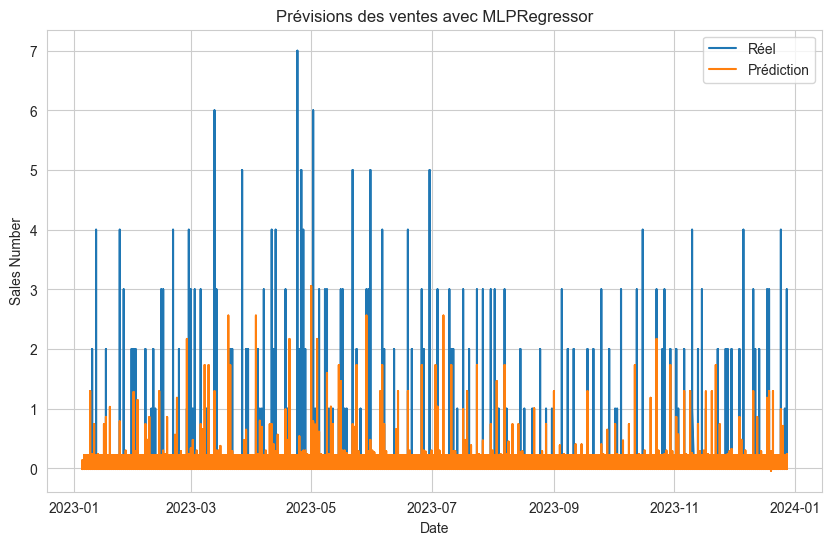

In [38]:
model = MLPRegressor(hidden_layer_sizes=(10,4),activation='relu',solver='adam')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Tracer les prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10,6))

plt.plot(y_test.index,y_test, label='Réel')
plt.plot(y_test.index, y_pred, label='Prédiction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales Number')
plt.title(f'Prévisions des ventes avec MLPRegressor')
plt.show()

Mean Squared Error: 0.018934936066946323


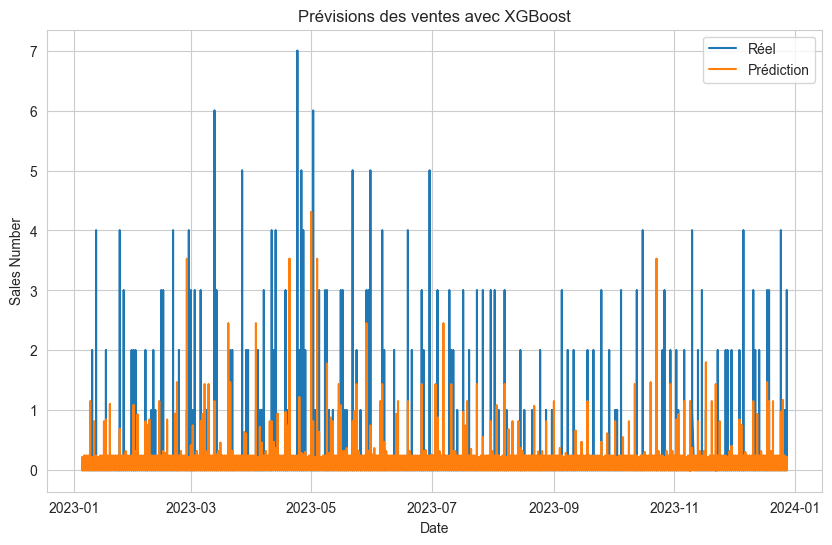

In [39]:
# Créer un modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Tracer les prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10,6))

plt.plot(y_test.index,y_test, label='Réel')
plt.plot(y_test.index, y_pred, label='Prédiction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales Number')
plt.title(f'Prévisions des ventes avec XGBoost')
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 959085, number of used features: 77
[LightGBM] [Info] Start training from score 0.009577
Mean Squared Error: 0.018996605054322217


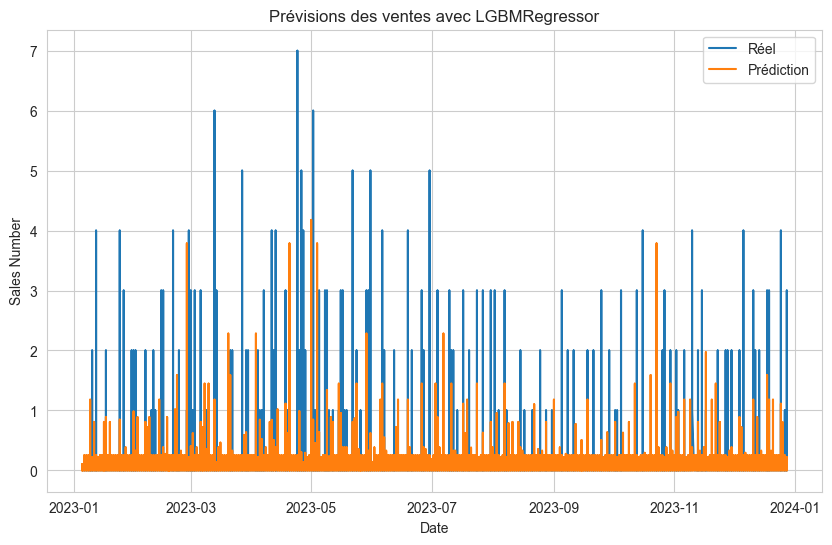

In [40]:
from lightgbm import LGBMRegressor

# Créer un modèle XGBoost
model = LGBMRegressor()

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Tracer les prédictions par rapport aux valeurs réelles
plt.figure(figsize=(10,6))

plt.plot(y_test.index,y_test, label='Réel')
plt.plot(y_test.index, y_pred, label='Prédiction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales Number')
plt.title(f'Prévisions des ventes avec LGBMRegressor')
plt.show()

In [78]:
def predict_for_future_date(df, product_code, country, target_date, model):

    # Step 1: Filter the data for the specific product and country
    product_country_data = df[(df['CodeProduit'] == product_code) & (df['Pays'] == country)]
    # Step 2: Create lags for the data (this includes historical data)
    product_country_data = create_lags(product_country_data)
    # Step 3: Find the most recent available date for the product-country combination
    latest_data = product_country_data[product_country_data.index <= target_date].tail(8)

    # If no data exists for the target date, we start from the most recent date available
    current_date = latest_data.index.values[-1]

    # Step 4: Forecast day-by-day, updating lags
    forecast_results = []
    while current_date < target_date:
        # Get the current sample for prediction (including lag features)
        current_sample = latest_data.tail(1)
        current_sample = preprocess_data(current_sample, encoder_exists=True)
        current_sample = current_sample.drop("sales_number", axis=1)
        # Step 5: Use the model to predict sales for the current date
        predicted_sales = model.predict(current_sample)
        # Store the result
        forecast_results.append({
            'Date': current_date,
            'predicted_sales': predicted_sales[0]
        })

        # Step 6: Update the dataset for the next day's forecast
        new_date = current_date + pd.Timedelta(days=1)

        # Create a new row and set the index as the new date
        new_row = pd.DataFrame({
            'CodeProduit': [product_code],
            'Pays': [country],
            'sales_number': [predicted_sales[0]],
            'sales_number_lag_1': [latest_data['sales_number'].values[-1]],
            'sales_number_lag_7': [latest_data['sales_number'].values[0]]
        }, index=[new_date])

        # Add the new row to the data
        latest_data = pd.concat([latest_data, new_row])

        # Move to the next day
        latest_data = latest_data.drop(latest_data.index[0])
        current_date = latest_data.index.values[-1]

    return forecast_results

In [85]:
product_code = '3x'
country = 'USA'
target_date = pd.to_datetime('2024-05-02')
forecast = predict_for_future_date(df, product_code, country, target_date, model)

# Display the forecasted sales for the target date
print(forecast)
print(forecast[-1].get("predicted_sales"))

[{'Date': numpy.datetime64('2023-12-28T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2023-12-29T00:00:00.000000000'), 'predicted_sales': 0.251093705909386}, {'Date': numpy.datetime64('2023-12-30T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2023-12-31T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2024-01-01T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2024-01-02T00:00:00.000000000'), 'predicted_sales': 0.6247554774793728}, {'Date': numpy.datetime64('2024-01-03T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2024-01-04T00:00:00.000000000'), 'predicted_sales': 0.6387771700843073}, {'Date': numpy.datetime64('2024-01-05T00:00:00.000000000'), 'predicted_sales': 0.21977264664754306}, {'Date': numpy.datetime64('2024-01-06T00:00:00.000000000'), 'predicted_sales': 0.6387771700843